In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0269

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 992ms/step - loss: 0.0202
Average validation loss: 0.6685857176780701
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0202 - val_loss: 0.6686
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0149 - val_loss: 0.6686
Average validation loss: 0.6606839299201965
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0149 - val_loss: 0.6646
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 932ms/step - loss: 0.0111 - val_loss: 0.6646
Average validation loss: 0.5222880840301514
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 950ms/step - loss: 0.0111 - val_loss: 0.6172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_da

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 864ms/step - loss: 8.6880e-05
Average validation loss: 0.5104022920131683
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 876ms/step - loss: 8.6880e-05 - val_loss: 0.5104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step - loss: 8.8497e-05 - val_loss: 0.5104
Average validation loss: 0.17397132143378258
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 801ms/step - loss: 8.8497e-05 - val_loss: 0.3422
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 792ms/step - loss: 8.5987e-05 - val_loss: 0.3422
Average validation loss: 0.23337824642658234
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - loss: 8.5987e-05 - val_loss: 0.3059
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 789ms/step - loss: 8.4690e-05 - val_loss: 0.3059
Averag

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 794ms/step - loss: 2.8733e-05
Average validation loss: 0.06836179147164027
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - loss: 2.8733e-05 - val_loss: 0.0684
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 789ms/step - loss: 3.3992e-05 - val_loss: 0.0684
Average validation loss: 0.1414939065774282
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 801ms/step - loss: 3.3992e-05 - val_loss: 0.1049
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 784ms/step - loss: 3.2157e-05 - val_loss: 0.1049
Average validation loss: 0.09934546301762263
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 796ms/step - loss: 3.2157e-05 - val_loss: 0.1031
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 787ms/step - loss: 2.9624e-05 - val_loss: 0.1031
Average validation loss: 0.0810403861105442
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 799ms/step - loss: 2.9624e-05 - val_loss: 0.0976
Epoch 5/10
12/12 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 871ms/step - loss: 9.8774e-06
Average validation loss: 0.017918982543051243
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 882ms/step - loss: 9.8774e-06 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 826ms/step - loss: 8.1784e-06 - val_loss: 0.0179
Average validation loss: 0.04683745640795678
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 836ms/step - loss: 8.1784e-06 - val_loss: 0.0324
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 823ms/step - loss: 7.1978e-06 - val_loss: 0.0324
Average validation loss: 0.08451653365045786
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - loss: 7.1978e-06 - val_loss: 0.0498
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 826ms/step - loss: 6.5436e-06 - val_loss: 0.0498
Average validation loss: 0.021353055257350206
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 837ms/step - loss: 6.5436e-06 - val_loss: 0.0427
Epoch 5/10
16

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 850ms/step - loss: 9.9342e-06
Average validation loss: 0.05066626276820898
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 860ms/step - loss: 9.9342e-06 - val_loss: 0.0507
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 833ms/step - loss: 8.4686e-06 - val_loss: 0.0507
Average validation loss: 0.020987931918352843
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 843ms/step - loss: 8.4686e-06 - val_loss: 0.0358
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 833ms/step - loss: 7.3393e-06 - val_loss: 0.0358
Average validation loss: 0.01672123624011874
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 843ms/step - loss: 7.3393e-06 - val_loss: 0.0295
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 882ms/step - loss: 1.2970e-05
Average validation loss: 0.010241808835417032
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 892ms/step - loss: 1.2970e-05 - val_loss: 0.0102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - loss: 9.0247e-06 - val_loss: 0.0102
Average validation loss: 0.01751028319510321
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 804ms/step - loss: 9.0247e-06 - val_loss: 0.0139
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 792ms/step - loss: 7.3283e-06 - val_loss: 0.0139
Average validation loss: 0.006547623119937877
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - loss: 7.3283e-06 - val_loss: 0.0114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 796ms/step - loss: 6.6579e-06 - val_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 769ms/step - loss: 1.1693e-05
Average validation loss: 0.03228170708753168
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 781ms/step - loss: 1.1693e-05 - val_loss: 0.0323
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 802ms/step - loss: 7.9209e-06 - val_loss: 0.0323
Average validation loss: 0.016589101881254464
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 814ms/step - loss: 7.9209e-06 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 818ms/step - loss: 6.1476e-06 - val_loss: 0.0244
Average validation loss: 0.024398219666909426
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 830ms/step - loss: 6.1476e-06 - val_loss: 0.0244
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 801ms/step - loss: 5.5043e-06 - val

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 823ms/step - loss: 5.1389e-06
Average validation loss: 0.009845322890517613
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - loss: 5.1389e-06 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 815ms/step - loss: 3.4177e-06 - val_loss: 0.0098
Average validation loss: 0.009609641167723263
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 827ms/step - loss: 3.4177e-06 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 798ms/step - loss: 2.7721e-06 - val_loss: 0.0097
Average validation loss: 0.01624584149491663
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 810ms/step - loss: 2.7721e-06 - val_loss: 0.0119
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 797ms/step - loss: 2.4264e-06 - v

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 797ms/step - loss: 2.7278e-06
Average validation loss: 0.012640166562050581
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 808ms/step - loss: 2.7278e-06 - val_loss: 0.0126
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 820ms/step - loss: 1.9783e-06 - val_loss: 0.0126
Average validation loss: 0.013712703316871609
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 831ms/step - loss: 1.9783e-06 - val_loss: 0.0132
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 827ms/step - loss: 1.6044e-06 - val_loss: 0.0132
Average validation loss: 0.012324828521481581
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 838ms/step - loss: 1.6044e-06 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 186s 837ms/step - loss: 1.3885e-06 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 791ms/step - loss: 1.9257e-06
Average validation loss: 0.027085177833214402
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 802ms/step - loss: 1.9257e-06 - val_loss: 0.0271
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 791ms/step - loss: 1.4528e-06 - val_loss: 0.0271
Average validation loss: 0.015541380882496014
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 802ms/step - loss: 1.4528e-06 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 794ms/step - loss: 1.2232e-06 - val_loss: 0.0213
Average validation loss: 0.01899563570623286
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 806ms/step - loss: 1.2232e-06 - val_loss: 0.0205
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 800ms/step - loss: 1.1176e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 1.2589e-06
Average validation loss: 0.020350291199671727
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 799ms/step - loss: 1.2589e-06 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 1.6832e-06 - val_loss: 0.0204
Average validation loss: 0.08887333826472361
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 1.6832e-06 - val_loss: 0.0546
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 793ms/step - loss: 1.4638e-06 - val_loss: 0.0546
Average validation loss: 0.017674669215921313
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 804ms/step - loss: 1.4638e-06 - val_loss: 0.0423
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 792ms/step - loss: 1.2141e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 791ms/step - loss: 1.4793e-06
Average validation loss: 0.018688962224405258
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 1.4793e-06 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 849ms/step - loss: 1.5573e-06 - val_loss: 0.0187
Average validation loss: 0.034802051121369006
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 860ms/step - loss: 1.5573e-06 - val_loss: 0.0267
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 796ms/step - loss: 1.5753e-06 - val_loss: 0.0267
Average validation loss: 0.025464706402271987
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 807ms/step - loss: 1.5753e-06 - val_loss: 0.0263
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 262s 802ms/step - loss: 1.4196e-06 - val_loss: 0.0263
Average validation loss: 0.01769473685417324
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 813ms/step - loss: 1.4196e-06 - val_loss: 0.0242
Saved

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 889ms/step - loss: 2.0038e-06
Average validation loss: 0.014848469222973412
96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 900ms/step - loss: 2.0038e-06 - val_loss: 0.0148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 163s 795ms/step - loss: 1.4626e-06 - val_loss: 0.0148
Average validation loss: 0.014778251468669623
96/96 ━━━━━━━━━━━━━━━━━━━━ 164s 806ms/step - loss: 1.4626e-06 - val_loss: 0.0148
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 245s 842ms/step - loss: 1.2300e-06 - val_loss: 0.0148
Average validation loss: 0.0178586039886189
96/96 ━━━━━━━━━━━━━━━━━━━━ 246s 853ms/step - loss: 1.2300e-06 - val_loss: 0.0158
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 323s 800ms/step - loss: 1.0757e-06 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 822ms/step - loss: 4.4476e-06
Average validation loss: 0.01748445789174487
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 834ms/step - loss: 4.4476e-06 - val_loss: 0.0175
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 199s 824ms/step - loss: 3.2288e-06 - val_loss: 0.0175
Average validation loss: 0.0204700557825466
120/120 ━━━━━━━━━━━━━━━━━━━━ 200s 835ms/step - loss: 3.2288e-06 - val_loss: 0.0190
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 299s 825ms/step - loss: 2.5417e-06 - val_loss: 0.0190
Average validation loss: 0.03380056600241611
120/120 ━━━━━━━━━━━━━━━━━━━━ 301s 836ms/step - loss: 2.5417e-06 - val_loss: 0.0239
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 396s 793ms/step - loss: 2.0902e-06 - val_loss: 0.0239
Average validation loss: 0.04324116042504708
120/120 ━━━━━━━━━━━━━━━━━━━━ 397s 805ms/step - loss: 2.0902e-06 - val_loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 3.3424e-06
Average validation loss: 0.01586091611372669
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 802ms/step - loss: 3.3424e-06 - val_loss: 0.0159
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 793ms/step - loss: 2.5433e-06 - val_loss: 0.0159
Average validation loss: 0.017331821536774643
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 804ms/step - loss: 2.5433e-06 - val_loss: 0.0166
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 794ms/step - loss: 2.0610e-06 - val_loss: 0.0166
Average validation loss: 0.050141403500068314
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 804ms/step - loss: 2.0610e-06 - val_loss: 0.0278
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 461s 792ms/step - loss: 1.7334e-06 - val_loss: 0.0278
Average validation loss: 0.01637294533914731
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 802ms/step - loss: 1.7334e-06 - val_l

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 788ms/step - loss: 1.5374e-06
Average validation loss: 0.01648427551263012
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 799ms/step - loss: 1.5374e-06 - val_loss: 0.0165
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 793ms/step - loss: 1.2390e-06 - val_loss: 0.0165
Average validation loss: 0.012316720330272802
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 804ms/step - loss: 1.2390e-06 - val_loss: 0.0144
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 823ms/step - loss: 1.0911e-06 - val_loss: 0.0144
Average validation loss: 0.011407191614853218
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 833ms/step - loss: 1.0911e-06 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 835ms/step - loss: 1.5088e-06
Average validation loss: 0.012475621090998175
200/200 ━━━━━━━━━━━━━━━━━━━━ 169s 846ms/step - loss: 1.5088e-06 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 328s 794ms/step - loss: 1.1783e-06 - val_loss: 0.0125
Average validation loss: 0.01161208634628565
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 805ms/step - loss: 1.1783e-06 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 492s 808ms/step - loss: 9.8171e-07 - val_loss: 0.0120
Average validation loss: 0.010293694969586795
200/200 ━━━━━━━━━━━━━━━━━━━━ 494s 819ms/step - loss: 9.8171e-07 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 792ms/step - loss: 1.1870e-06
Average validation loss: 0.012899469070058936
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 803ms/step - loss: 1.1870e-06 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 379s 778ms/step - loss: 9.1002e-07 - val_loss: 0.0129
Average validation loss: 0.00867138480950113
240/240 ━━━━━━━━━━━━━━━━━━━━ 382s 789ms/step - loss: 9.1002e-07 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 577s 811ms/step - loss: 7.8401e-07 - val_loss: 0.0108
Average validation loss: 0.01647558924832803
240/240 ━━━━━━━━━━━━━━━━━━━━ 579s 821ms/step - loss: 7.8401e-07 - val_loss: 0.0127
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 775s 819ms/step - l

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.23714516915380954, 0.1753539487719536, 0.05751403314061462, 0.04008959442493506, 0.014305098722921683, 0.017346930676721967, 0.02266847035905812, 0.013660125882015563, 0.013012468129995146, 0.019465403511057956, 0.028646135061280803, 0.017210988145845475, 0.02645385788161851, 0.020622312677674923, 0.01849471516347781, 0.011443097170284092, 0.010736059888767252, 0.009840487828091066]
std_val_losses =  [0.17867827887528365, 0.15048665676898937, 0.03375171164839258, 0.05044911282404518, 0.008529896328504462, 0.009776367686632202, 0.009534423615112314, 0.0047609543185955705, 0.008715458404073558, 0.03141041023663668, 0.03105737462545414, 0.015793983522138965, 0.02308083714516682, 0.017312356824724567, 0.010492394168415685, 0.003280223781313866, 0.003603666815557141, 0.003038626625902351]


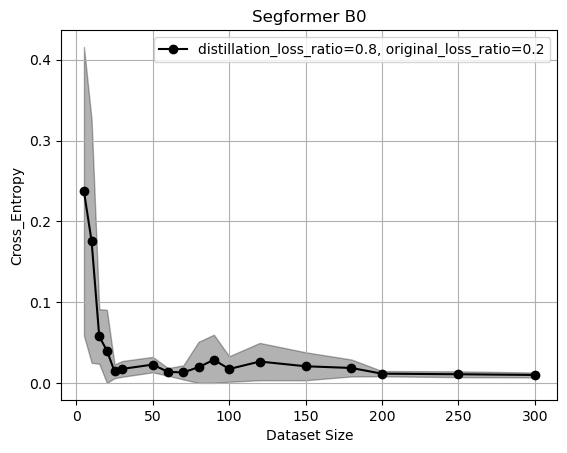

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()